# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

# План проекта

1. [Подготовка данных](#подготовка)

    - [чтение данных](#чтение)
    - [предобработка данных](#предобработка)
    - [эффективность обогащения](#эффективность)
    - [признаки, недоступные в тестовой выборке](#недоступные)
    
    
2. [Анализ данных](#анализ)

    - [изменение концентрации элементов на каждом этапе тех. процесса](#концентрации)
    - [распределение размеров гранул сырья](#гранулы)
    - [суммарная концентрация](#суммарная_концентрация)
    - [обработка аномалий](#аномалии)
    
    
3. [Модель](#модель)

    - [функция для вычисления sMAPE](#sMAPE)
    - [признаки](#признаки)
    - [стандартизация данных](#стандартизация)
    - [линейная регрессия](#ЛР)
    - [случайный лес](#лес)
    - [полиномиальная регрессия](#ПР)
    - [сравнение моделей](#сравнение)
    
[Вывод](#вывод)

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import cross_val_score as cv

from sklearn.metrics import make_scorer
from statistics import mean

from sklearn.ensemble import RandomForestRegressor as FOREST
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor

In [2]:
# настройка отображения датафреймов

pd.set_option('display.max_columns', 500)

<a id="подготовка"></a>

# 1. Подготовка данных

<a id="чтение"></a>

### Чтение данных

In [3]:
# читаем файлы

try:

    full = pd.read_csv('gold_recovery_full.csv', index_col=['date'])
    test = pd.read_csv('gold_recovery_test.csv', index_col=['date'])
    train = pd.read_csv('gold_recovery_train.csv', index_col=['date'])
    
except:
    
    full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col=['date'])
    test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col=['date'])
    train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col=['date'])

In [4]:
# первые 5 строк полной таблицы + информация о столбцах

display(full.head())
full.info()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_cleaner.i

In [5]:
# первые 5 строк обучающей выборки + информация о столбцах

display(train.head(5))
train.info()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_cleaner.i

In [6]:
# первые 5 строк тестовой выборки + информация о столбцах

display(test.head())
test.info()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                         584

<a id="предобработка"></a>

### Предобработка данных

С пропущенными значениями поступим следующим образом - снова воспользуемся заполнением пропусков методом **ffill** (так как в постановке задачи сказано,  что данные, полученные в близкие моменты времени, похожи), но перед этим удалим все строки, для которых пропущенно хотя бы одно из целевых значений  - `rougher.output.recovery` и `final.output.recovery`

In [7]:
# удаляем строки с пропусками в целевых признаках

full_filled = full.dropna(subset=['rougher.output.recovery', 'final.output.recovery']).copy()

# заполняем оставшиеся пропуски предыдущим значением

full_filled.fillna(method = 'ffill', inplace=True)

Теперь уберем пропуски в обучающей выборке

In [8]:
# удаляем строки с пропусками в целевых признаках в обучающей выборке

train_interim = train.dropna(subset=['rougher.output.recovery', 'final.output.recovery']).copy()

train_filled = full_filled.loc[train_interim.index, train.columns].copy()

In [9]:
train_filled.shape

(14149, 86)

Проверим - есть ли пропуски в тестовой выборке

In [10]:
# пропуски в тетстовой выборке

test.isna().sum()

primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


Попробуем избавиться от пропусков так же, как в случае обучающей выборки

In [11]:
# выбираем из полной заполненной таблицы данных те строки и столбцы, которые изначально были в тестовой выборке

test_filled = full_filled.loc[test.index, test.columns].copy()

# считаем количество пропусков в новой тестовой выборке

test_filled.isna().sum()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


primary_cleaner.input.sulfate                 566
primary_cleaner.input.depressant              566
primary_cleaner.input.feed_size               566
primary_cleaner.input.xanthate                566
primary_cleaner.state.floatbank8_a_air        566
primary_cleaner.state.floatbank8_a_level      566
primary_cleaner.state.floatbank8_b_air        566
primary_cleaner.state.floatbank8_b_level      566
primary_cleaner.state.floatbank8_c_air        566
primary_cleaner.state.floatbank8_c_level      566
primary_cleaner.state.floatbank8_d_air        566
primary_cleaner.state.floatbank8_d_level      566
rougher.input.feed_ag                         566
rougher.input.feed_pb                         566
rougher.input.feed_rate                       566
rougher.input.feed_size                       566
rougher.input.feed_sol                        566
rougher.input.feed_au                         566
rougher.input.floatbank10_sulfate             566
rougher.input.floatbank10_xanthate            566


Пропуски не исчезли, при этом в каждом столбце равное количество пропусков. Т.е. скорее всего в новой тестовой выборке просто есть целиком незаполненные строки, причем их 566. Скорее всего это связано с тем, что в тестовой выборке изначально были данные, которые мы удалили из полной таблицы, так как у них были пропуски в целевых признаках. А при формировании новой тестовой выборки мы передали индексы, которых уже нет в таблице `full_filled`.

**P.S. на это намекает и предупреждение, которое появляется при первом запуске этой ячейки**

Посмотрим насколько много данных мы потеряли таким образом

In [12]:
print('в тестовой выборке потеряно {:.2%} данных'.format(566/test.shape[0]))

в тестовой выборке потеряно 9.67% данных


С одной стороны, можно сказать, что чуть меньше 10% данных - это достаточно много. С другой сторны, у нас не было другого выхода - так как эти данные содержали ошибку в целевом признаке, а значит обучение и/или проверка модели на таких данных в дальнейшем привела бы к неправильным прогнозам на производстве и, следовательно, к убыткам.

Т.е. нам не остается ничего другого, кроме как удалить незаполненные строки из новой тестовой выборки

In [13]:
# удаляем пропушенные строки из тестовой выборки

test_filled.dropna(inplace = True)

# проверяем отсутствие пропусков

test_filled.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

<a id="эффективность"></a>

### Эффективность обогащения

\begin{equation}
    Recovery = \frac{C \cdot (F-T)}{F \cdot (C-T)} \cdot 100 \%
\end{equation}

\begin{equation}
    C - доля \ золота \ после \ флотации/второй \ очистки
    \\
    F - доля \ золота \ до \ флотации/второй \ очистки
    \\
    T - доля \ золота \ в \ отвальных \ хвостах \ после \ флотации/второй \ очистки
\end{equation}

In [14]:
# функция для рассчета эффективности обогащения

def Recovery(C,F,T):
    
    res = (C*(F-T))/(F*(C-T)) * 100
    
    return res

Иными словами:


|Величина||Флотация||Очистка|
|--------||--------||-------|
|C | rougher.output.concentrate_au||final.output.concentrate_au|
|F | rougher.input.feed_au||primary_cleaner.output.concentrate_au|
|T | rougher.output.tail_au||secondary_cleaner.output.tail_au|
|Recovery | rougher.output.recovery||final.output.recovery|

Чтобы проверить  правильность вычисления эффективности обогащения на обучающей выборке - выделим  C, F, T и Recovery в отдельную таблицу для удобства работы

Создаем отдельную таблицу для проверки правильности рассчета **recovery**

In [15]:
# таблица для проверки величины recovery на обучающей выборке

recovery_check = train_filled[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']].copy()
recovery_check.set_index(train_filled.index, drop=True)

# рассчитываем recovery с помощью нашей функции

recovery_check['recovery_manual'] = Recovery(recovery_check['rougher.output.concentrate_au'], recovery_check['rougher.input.feed_au'], recovery_check['rougher.output.tail_au'])

# проверим пропуски в таблице

recovery_check.isna().sum()

rougher.output.concentrate_au    0
rougher.input.feed_au            0
rougher.output.tail_au           0
rougher.output.recovery          0
recovery_manual                  0
dtype: int64

In [16]:
# рассчитываем MAE

mae = MAE(recovery_check['rougher.output.recovery'], recovery_check['recovery_manual'])
mean = recovery_check['rougher.output.recovery'].mean()

print('Среднее значение = {:.2f} ; MAE = {:.2f}'.format(mean, mae))

Среднее значение = 82.70 ; MAE = 0.00


Четко видно,  что во всех возможных случаях параметр **recovery** рассчитан правильно

<a id="недоступные"></a>

### Признаки, недоступные в тестовой выборке

In [17]:
# сохраним все признаки, которые есть в обучающей выборке, но отсутствуют в тестовой и выведем их на экран

train_features = train_filled.columns

test_features = test.columns

missed_features = []

for feature in train_features:
    
    if feature not in test_features:
        print(feature)
        missed_features.append(feature)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

В тестовой выборке **отстутсвуют данные об отвальных хвостах** на всех этапах. Вероятно это связано с тем, что к тому моменту как получаются данные об отвальных хвостах, вся порода (или большая ее часть) уже отработана и делать предсказания об эффективности обогащения золота по этим данным уже бесполезно.

Также **отсутствуют данные о параметрах сырья, после первичной обработки**. Вероятно это связано с тем, что они не очень важны, так как сырье в любом случае отправится на вторичную обработку.

**Отсутсвуют данные о финальных концентрациях серебра, свинца, sol(чем бы это ни было) и золота**. Ожидаемо, так как это фактически целевые признаки (ну конкретно в этом проекте целевым является только признак, связанный с золотом).

Также **отсутсвует группа признаков вида `rougher.calculation.*`** - их скорее всего можно восстановить или из полных данных или из логики названия признака. С другой стороны - в постановке задачи сказано, что в тестовой выборке не доступны те признаки, которые **"замеряются и/или рассчитываются значительно позже"**. Т.е. несмотря на тот факт, что значения этой группы признаков мы можем получить в ручную, модель, обученная на этих признаках, не будет иметь практического смысла, т.к. для ее работы будут нужны признаки, недоступные на этапе предсказания.

Исходя из предложенных причин отсутствия признаков в тестовой выбрке, мы также не будем использовать их при обучении модели, т.к. часть из них является достаточно бесполезными (т.к. их значения никак не повлияют на ход технологического процесса), а часть, скорее всего, недоступна на этапе предсказания

<a id="анализ"></a>

# 2. Анализ данных

<a id="концентрации"></a>

### Изменение концентрации элементов на каждом этапе тех. процесса

Выделим столбцы с концентрациями трех веществ в три отдельных датафрейма, так будет удобнее наблюдать за изменением концентраций на всех этапах

In [18]:
concentrations_ag = (['rougher.input.feed_ag',
                      'rougher.output.concentrate_ag',
                   'primary_cleaner.output.concentrate_ag',
                     'final.output.concentrate_ag'])

concentrations_pb = (['rougher.input.feed_pb',
                      'rougher.output.concentrate_pb',
                   'primary_cleaner.output.concentrate_pb',
                    'final.output.concentrate_pb'])

concentrations_au = (['rougher.input.feed_au',
                      'rougher.output.concentrate_au',
                   'primary_cleaner.output.concentrate_au',
                    'final.output.concentrate_au'])


ag_data = full_filled[concentrations_ag]
pb_data = full_filled[concentrations_pb]
au_data = full_filled[concentrations_au]

display(ag_data.describe())
print()
display(pb_data.describe())
print()
display(au_data.describe())

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.794927,11.994759,8.442408,5.168387
std,1.936847,2.733862,2.054465,1.372362
min,0.010000,0.000000,0.000000,0.000000
25%,7.237967,10.628337,7.263288,4.251000
50%,8.593574,12.098115,8.507298,5.066039
75%,10.213771,13.736996,9.809001,5.895401
max,14.596026,24.480271,16.081632,16.001945


,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,3.585096,7.606272,9.810317,9.978821
std,1.062972,1.796757,2.572253,1.669228
min,0.010000,0.000000,0.000000,0.000000
25%,2.872178,6.725987,8.676500,9.137225
50%,3.528235,7.742580,10.142270,10.102264
75%,4.241005,8.565199,11.416298,11.035644
max,7.142594,13.617072,17.081278,17.031899


,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.266097,19.772000,32.119400,44.076513
std,1.955092,3.753600,5.627611,5.129784
min,0.010000,0.000000,0.000000,0.000000
25%,6.854384,18.802523,30.463140,43.402215
50%,8.125839,20.280214,32.841295,45.011244
75%,9.769917,21.717843,35.048006,46.275313
max,13.731330,28.824507,45.933934,52.756638


Таблицы содержат много информации, но они не слишком наглядны. Построим боксплоты

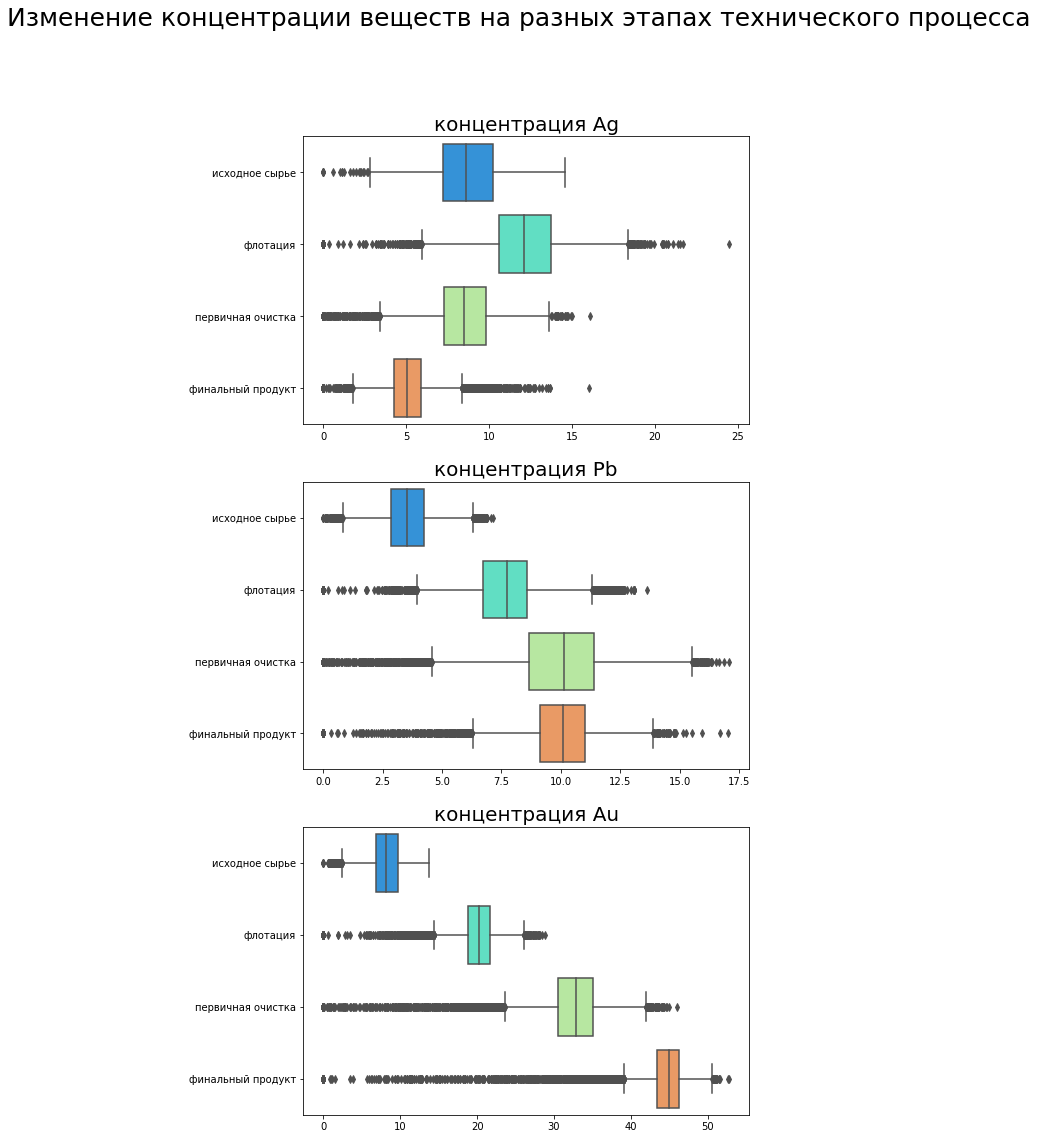

In [19]:
data = [ag_data, pb_data, au_data]
titles = ['концентрация Ag', 'концентрация Pb', 'концентрация Au']
y_labels = ['исходное сырье','флотация', 'первичная очистка', 'финальный продукт']

fig, ax = plt.subplots(3,1, figsize=(8, 18))

for i in range(3):
    
    sns.boxplot(data=data[i], palette='rainbow', ax=ax[i], orient='h')
    ax[i].set_title(label=titles[i], fontsize=20)
    ax[i].set_yticklabels(y_labels)
    
fig.suptitle('Изменение концентрации веществ на разных этапах технического процесса', fontsize=25)
plt.show()

Стоит отметить три интересеные особенности:

1. Концентрация свинца практически не изменяется после первичной очистки

2. Концентрации золота и серебра ведут себя противоположным образом: концентрация золота увеличивается по пути к финальному продукту (что логично, т.к. добывается именно золото), а концентрация серебра, наоборот, уменьшается. Возможно это связано с тем, что реагенты, применяемые для очистки руды и выделения золота, при этом разлагают серебро

3. Флотация повышает концентрацию всех металлов


Ну и можно поздравить себя с небольшой победой - концентрация ни одного из веществ ни на одном из этапов не превысила 100

In [20]:
#  очистим промежуточную таблицу data

del data

<a id="гранулы"></a>

### Распределения размеров гранул сырья

Размер гранул сырья хранится в признаке `rougher.input.feed_size`. Чтобы оценить распределние размеров построим два графика - гистограмму и боксплот

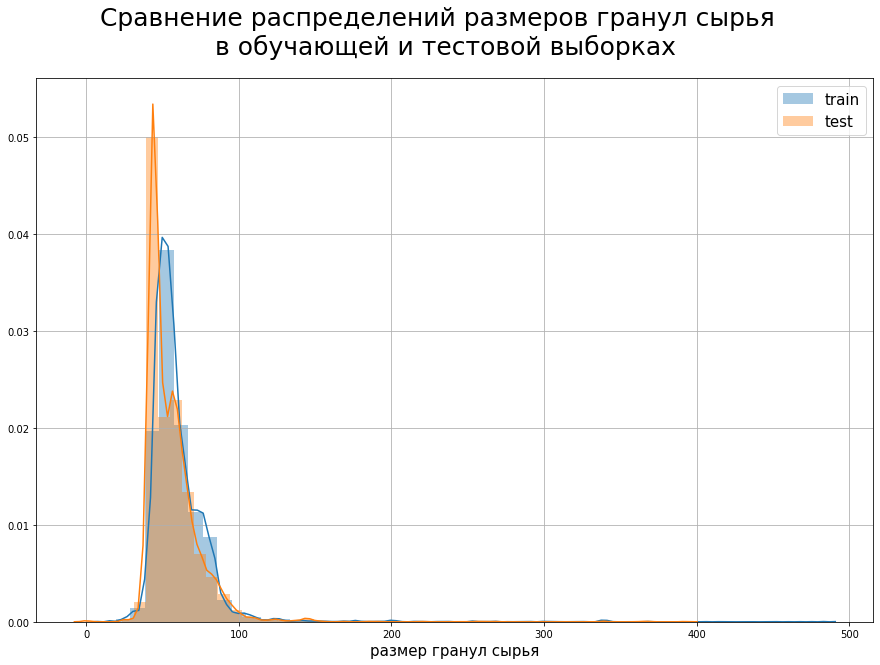

In [21]:
fig, ax = plt.subplots(figsize=(15,10))

data = [train_filled, test_filled]
legend_labels = ['train', 'test']

for i in range(2):
    sns.distplot(data[i]['rougher.input.feed_size'], ax=ax, label=legend_labels[i])
    
ax.legend(fontsize=15)
ax.grid()
ax.set_xlabel('размер гранул сырья', fontsize=15)
fig.suptitle('Сравнение распределений размеров гранул сырья \n в обучающей и тестовой выборках', fontsize=25)
plt.show()

Есть некритичные различия в распеределениях. Тем не менее форма распределений и положение основного пика достаточно близки. К тому же стоит учесть,  что при обученни моделей мы стандартизируем все признаки.

<a id="суммарная_концентрация"></a>

### Суммарная концентрация

Для начала рассчитаем суммарные концентрации на всех этапах

In [22]:
# считаем суммарные концентрации

feed = ag_data['rougher.input.feed_ag'] + au_data['rougher.input.feed_au'] + pb_data['rougher.input.feed_pb']

rougher_output = ag_data['rougher.output.concentrate_ag'] + au_data['rougher.output.concentrate_au'] + pb_data['rougher.output.concentrate_pb']

final_output = ag_data['final.output.concentrate_ag'] + au_data['final.output.concentrate_au'] + pb_data['final.output.concentrate_pb']

# создаем датафрейм с суммарными концентрациями

conc_data = pd.DataFrame(data = {'feed':feed, 'rougher_output':rougher_output, 'final_output':final_output}, index  = au_data.index)
conc_data.describe()

,feed,rougher_output,final_output
count,19439.000000,19439.000000,19439.000000
mean,20.646120,39.373032,59.223721
std,4.480027,6.863389,6.095138
min,0.030000,0.000000,0.000000
25%,17.252879,38.394639,59.298323
50%,20.141216,40.312648,60.306921
75%,23.797381,42.365102,61.096667
max,33.498784,55.568687,64.968881


Теперь можно посторить боксплоты

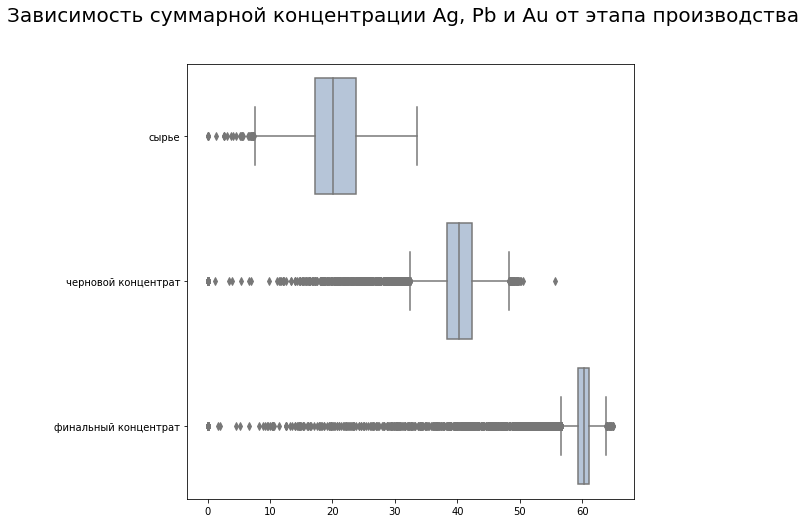

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

sns.boxplot(data=conc_data, color='lightsteelblue', ax=ax, orient='h')
ax.set_yticklabels(['сырье', 'черновой концентрат', 'финальный концентрат'])
fig.suptitle('Зависимость суммарной концентрации Ag, Pb и Au от этапа производства', fontsize=20)
plt.show()

Ни на одном из этапов суммарная концентрация не превысила 100. Также суммарная коцнентрация нигде не опустилась ниже 0. Т.е. можно сказать, что **аномальных значений нет**.

<a id="аномалии"></a>

### Обработка аномалий

Есть ряд строк, в которых суммарная концентрация равна нулю. Удалим эти строки из обучающей и тестовой выборок

In [24]:
# получаем список индексов строк, для которых суммарная концентрация хоть на одном из этапов равна 0

anomaly_index = conc_data.query('feed == 0 or rougher_output == 0 or final_output == 0').index

# удаляем такие строки из обучающей и тестовой выборок

train_filled.drop(anomaly_index, axis=0, inplace=True, errors='ignore')
test_filled.drop(anomaly_index, axis=0, inplace=True, errors='ignore')

<a id="модель"></a>

# 3. Модель

В этой задаче используем метрику качетсва sMAPE:

\begin{equation}
    smape = \frac{1}{N} \sum_{i=1}^{N} 2\frac{|y_i - \hat{y_i}|}{|y_i + \hat{y_i}|} \cdot 100\%
\end{equation}

При этом итоговая метрика будет рассчитываться так:

\begin{equation}
   Итоговое \  smape = 25\% \cdot smape(rougher) + 75\% \cdot smape(final)
\end{equation}

<a id="sMAPE"></a>

### Функция для вычисления sMAPE

In [25]:
# функция для нахождения итогового sMAPE

"""
получает на вход два массива (*, 2):

    - первый массив - правильные значения
    - второй массив - предсказания
    
в каждом массиве каждый элемент состоит из списка с 2 элементами:

    - первый элемент - rougher.output.recovery
    - второй элемент - final.output.recovery
    
возвращает итоговый sMAPE
"""

def total_sMAPE(true, pred):
    
    arr_sMAPE = sum(abs(true - pred)) / (sum(abs(true + pred)) / 2) * 100
    
    return arr_sMAPE[0] * 0.25 + arr_sMAPE[1] * 0.75

Далее в проекте мы будем использовать кросс-валидацию. Поэтому, чтобы использовать в качестве метрики оценивания нашу функцию total_sMAPE. Необходимо воспользоваться `sklearn.metrics.make_scorer`

In [26]:
# создаем кастомную метрику

sMAPE_scorer = make_scorer(total_sMAPE, greater_is_better=False)

Создадим словари для хранения sMAPE для каждой модели и времени ее обучения

In [27]:
# словари для храения иформации об использованных моделях

sMAPE_dict = {}
time_dict = {}

<a id="признаки"></a>

### Признаки

Нам нужно предсказать сразу две величины - `rougher.output.recovery` и `final.output.recovery`.

Для начала удалим из обучающей выборки признаки, недоступные в тестовой (мы сохранили их ранее в списке *missed_features*). А также выделим целевые признаки.

In [28]:
# оставляем для предсказания только признаки, доступные в тестовой выборке

features_train = train_filled.drop(missed_features, axis=1)

# выделяем целевые признаки

target_train = train_filled[['rougher.output.recovery', 'final.output.recovery']]

<a id="стандартизация"></a>

### Стандартизация данных

А теперь проведем стандартизацию признаков

In [29]:
# стандартизируем признаки с помощью StandartScaler

scaler = StandardScaler()
scaler.fit(features_train)

features_train_norm = pd.DataFrame(data = scaler.transform(features_train),
                                   columns=features_train.columns,
                                   index=features_train.index)

<a id="ЛР"></a>

### Линейная регрессия

Для начала попробуем самую простую модель - линейную регрессию

In [30]:
# создаем модель линейной регрессии

LR_model = LR()

# обучаем модель и оцениваем ее качество кросс валидацией на 5 подвыборках, метрика - sMAPE. выводим результаты на экран

print(cv(LR_model, features_train_norm.values, target_train.values, cv=5, scoring=sMAPE_scorer, n_jobs=-1))

list_sMAPE = abs(cv(LR_model, features_train_norm.values, target_train.values, cv=5, scoring=sMAPE_scorer,n_jobs=-1))

print('Значение sMAPE на обучающей выборке для модели ЛИНЕЙНОЙ РЕГРЕССИИ =', sum(list_sMAPE)/list_sMAPE.shape[0])

sMAPE_dict.update({'линейная регрессия' : sum(list_sMAPE)/list_sMAPE.shape[0]})
time_dict.update({'линейная регрессия' : 1.56})

[-11.55269538  -8.63688588  -8.16452797  -7.75532    -12.24525783]
Значение sMAPE на обучающей выборке для модели ЛИНЕЙНОЙ РЕГРЕССИИ = 9.670937412072135


In [31]:
# создаем модель линейной регрессии

LR_model = LR()
LR_model.fit(features_train_norm.values, target_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<a id="лес"></a>

### Случайный лес

Теперь используем модель случайного леса. Для подбора наилучших параметров воспользуемся `GridSearchCV`

In [32]:
"""
%%time

# подбираем лучшие параметры для модели случайного леса - количество дреевьев от 1 до 150, глубина от 1 до 20
# обучение проводим сразу на всех ядрах процессора - параметр n_jobs=-1
# делим обучающую выборку на 3 и используем кросс валидацию

gs = GridSearchCV(FOREST(random_state=42),
                        param_grid={'n_estimators': range(1,151,10), 'max_depth': range(1,11)},
                        scoring=sMAPE_scorer,
                        n_jobs=-1,
                        cv=3,
                        return_train_score=True)

gs.fit(features_train_norm.values, target_train.values)

# выводим лучшие параметры на экран

gs.best_params_
"""

"\n%%time\n\n# подбираем лучшие параметры для модели случайного леса - количество дреевьев от 1 до 150, глубина от 1 до 20\n# обучение проводим сразу на всех ядрах процессора - параметр n_jobs=-1\n# делим обучающую выборку на 3 и используем кросс валидацию\n\ngs = GridSearchCV(FOREST(random_state=42),\n                        param_grid={'n_estimators': range(1,151,10), 'max_depth': range(1,11)},\n                        scoring=sMAPE_scorer,\n                        n_jobs=-1,\n                        cv=3,\n                        return_train_score=True)\n\ngs.fit(features_train_norm.values, target_train.values)\n\n# выводим лучшие параметры на экран\n\ngs.best_params_\n"

In [33]:
%%time

# инициируем модель случайного леса с подобранными параметрами

FOREST_model = FOREST(random_state=42,
               max_depth = 3,
               n_estimators=50,
                     n_jobs=-1)

FOREST_model.fit(features_train_norm.values, target_train.values)
pred = FOREST_model.predict(features_train_norm.values)

best_sMAPE = total_sMAPE(target_train.values, pred)

print('Значение sMAPE на обучающей выборке для модели СЛУЧАЙНОГО ЛЕСА =', best_sMAPE)

sMAPE_dict.update({'случайный лес' : best_sMAPE})
time_dict.update({'случайный лес' : 41*60 + 42 + 18.5})

Значение sMAPE на обучающей выборке для модели СЛУЧАЙНОГО ЛЕСА = 7.116137975346621
CPU times: user 9.43 s, sys: 12.5 ms, total: 9.45 s
Wall time: 9.51 s


<a id="ПР"></a>

### Полиномиальная регрессия

Мы уже обучили две модели - линейную регрессию и случайный лес:

1. линейная регрессия - очень быстро обучается, но не обладает значительной гибкостью для подгонки к данным

2. случайный лес - обучение занимает катастрофическое количество времени, но модель получается достаточно гибкой

попробуем теперь обучить модель полиномиальной регрессии, которая должна обучаться значительно быстрее, чем модель случайного леса, но при этом показать гораздо лучший результат, чем модель линейной регрессии

In [34]:
%%time

# полиномиальная регрессия 2 степени

PR_2_model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LR())])

PR_2_model.fit(features_train_norm.values, target_train.values)

pred = PR_2_model.predict(features_train_norm.values)


print('Значение sMAPE на обучающей выборке для модели ПОЛИНОМИАЛЬНОЙ РЕГРЕССИИ 2 =', total_sMAPE(target_train.values, pred))

sMAPE_dict.update({'полиномиальная регрессия 2' : total_sMAPE(target_train.values, pred)})
time_dict.update({'полиномиальная регрессия 2' : 1.57})

Значение sMAPE на обучающей выборке для модели ПОЛИНОМИАЛЬНОЙ РЕГРЕССИИ 2 = 4.463650829734
CPU times: user 16.2 s, sys: 10.4 s, total: 26.6 s
Wall time: 26.9 s


<a id="сравнение"></a>

### Сравнение моделей

Для начала приведем результаты, полученные на обучающей выборке

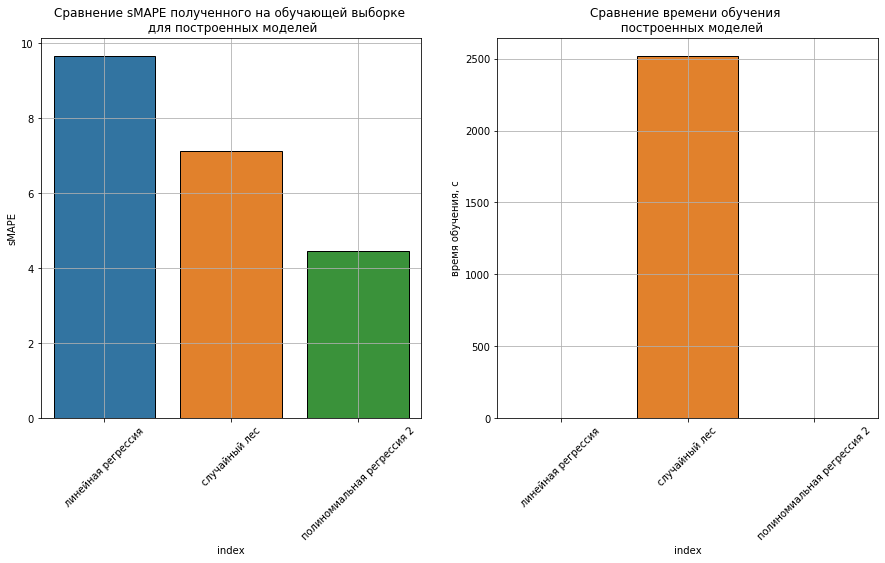

In [35]:
# создаем датафрейм с сохраненными значениями sMAPE и времени обучения для всех построенных моделей

bar_data = pd.DataFrame(data={'sMAPE':sMAPE_dict, 'time':time_dict})
bar_data.reset_index(inplace=True)

# строим две столбчатые диаграммы

fig, ax = plt.subplots(1,2, figsize=(15,7))

sns.barplot(x='index', y='sMAPE', data=bar_data, ax=ax[0], edgecolor='black')
ax[0].set_title('Сравнение sMAPE полученного на обучающей выборке \n для построенных моделей')
ax[0].grid()
ax[0].set_xticklabels(labels = bar_data['index'].values, rotation=45)

sns.barplot(x='index', y='time', data=bar_data, ax=ax[1], edgecolor='black')
ax[1].set_title('Сравнение времени обучения \n  построенных моделей')
ax[1].grid()
ax[1].set_ylabel('время обучения, с')
ax[1].set_xticklabels(labels = bar_data['index'].values, rotation=45)

plt.show()

Получили практически то, что ожидали:

1) линейная регрессия обучается практически мгновенно, но имеет самое высокое значение sMAPE

2) модель случайного леса обучается чрезвычайно долго, но ошибка значительно снижается, по сравнению с моделью линейной регрессии

3) модель полиномиальной регрессии 3 обучается среднее количество времени. При этом, значение sMAPE фактически равно 0. Вероятно это может быть связано с переобучением модели. Понятно будет только после проверки модели на тестовой выборке

4) модель полиномиальной регресси 2 обучается также быстро, как и модель линейной регресии. При этом ошибка ниже, чем у модели случайного леса

Теперь проверим модели на тестовой выборке

In [36]:
# целевые признаки для тестовой выборки

test_target = full_filled.loc[test_filled.index, ['rougher.output.recovery', 'final.output.recovery']]

# стандартизируем признаки в тестовой выборке

test_features = pd.DataFrame(data = scaler.transform(test_filled),
                                   columns=test_filled.columns,
                                   index=test_filled.index)

In [37]:
# проверяем модели на тестовой выборке

pred_linear = LR_model.predict(test_features)
pred_forest = FOREST_model.predict(test_features)
pred_poly_2 = PR_2_model.predict(test_features)


print('Значение sMAPE на обучающей выборке для модели ЛИНЕЙНОЙ РЕГРЕССИИ =', total_sMAPE(test_target.values, pred_linear))
print('Значение sMAPE на обучающей выборке для модели ПОЛИНОМИАЛЬНОЙ РЕГРЕССИИ 2 =', total_sMAPE(test_target.values, pred_poly_2))

print()
print('Значение sMAPE на обучающей выборке для модели СЛУЧАЙНОГО ЛЕСА =', total_sMAPE(test_target.values, pred_forest))


Значение sMAPE на обучающей выборке для модели ЛИНЕЙНОЙ РЕГРЕССИИ = 7.341495152796542
Значение sMAPE на обучающей выборке для модели ПОЛИНОМИАЛЬНОЙ РЕГРЕССИИ 2 = 21.36274355149324

Значение sMAPE на обучающей выборке для модели СЛУЧАЙНОГО ЛЕСА = 6.759746838322219


Для того, чтобы проверить построенные модели на адекватность - посчитаем sMAPE константной модели. Поскольку в идеальной случае sMAPE = 0, а в числителе формулы стоит модуль разности предсказания и реального значения, то сделаем так, чтобы константная модель всегда предсказывала медиану. Т.к. медиана минимизирует модуль разности

In [38]:
# константная модель

DUMMY = DummyRegressor(strategy='median')
DUMMY.fit(features_train_norm.values, target_train.values)

pred_dummy = DUMMY.predict(test_features)

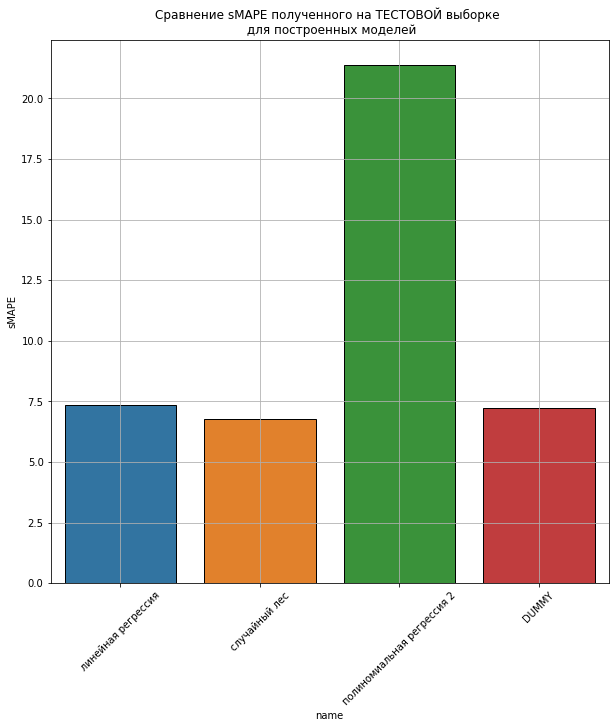

In [39]:
# построим столбчатую диграмму

data_test_bars = pd.DataFrame(data={'name':['линейная регрессия',
                                            'случайный лес',
                                            'полиномиальная регрессия 2',
                                           'DUMMY'],
                                   'sMAPE': [total_sMAPE(test_target.values, pred_linear),
                                            total_sMAPE(test_target.values, pred_forest),
                                            total_sMAPE(test_target.values, pred_poly_2),
                                            total_sMAPE(test_target.values, pred_dummy)]})


fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(x='name', y='sMAPE', data=data_test_bars, ax=ax, edgecolor='black')
ax.set_title('Сравнение sMAPE полученного на ТЕСТОВОЙ выборке \n для построенных моделей')
ax.grid()
ax.set_xticklabels(labels =['линейная регрессия', 'случайный лес', 'полиномиальная регрессия 2', 'DUMMY'], rotation=45)

plt.show()

<a id="вывод"></a>

## Вывод

Самой выгодной оказалась модель **линейной регрессии** т.к. ее значение sMAPE на тестовой выборке не намного превышает значение, продемонстрированное моделью случайного леса, а время обучения при этом значительно меньше

Оказалось, что две модели полиномиальной регрессии, казавшиеся самыми перспективынми на обучающей выборке, оказались переобученными